# What results my correlation functions yield on the galactic dust maps? How do these results compare with what the papers have shown?

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import pandas as pd

from itertools import product

from tqdm.notebook import tqdm

from ipywidgets import interact
import ipywidgets as widgets

from astropy.io import fits
from astropy.visualization import PercentileInterval, ZScaleInterval

from astropy.coordinates import SkyCoord
from astropy import units as u

from ModuleA import DataGrid, HealpyObj, Grid2d
import Statsfunctions as statsfunc
import GSMfunctions as gsmfunc
import LSSfunctions as lssfunc

full_path_ref = '/Users/williiamlaplante/Research/SynchrotronMaps/data/ReferenceSamples/'
full_path_dust = '/Users/williiamlaplante/Research/SynchrotronMaps/data/DustMapsData/'

## Reference sample

In [32]:
refsample = fits.open(full_path_ref + 'full_ref_sample.fits')[1].data
ra = refsample['RA']
dec = refsample['DEC']
z = refsample['Z']

grid = Grid2d([min(ra),max(ra)], [min(dec),max(dec)], (100,100))
grid.set_frame('fk5')

(-9.08293437957763, 67.11656388969517)

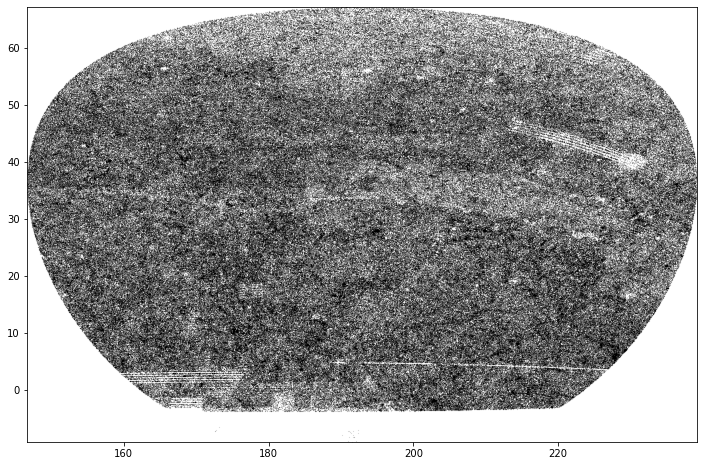

In [3]:
#Scatter plot to visualize limits of reference sample
plt.figure(figsize=(12,8))
plt.plot(ra, dec, '.', color='black', markersize=0.1)
plt.xlim(min(ra), max(ra))
plt.ylim(min(dec), max(dec))

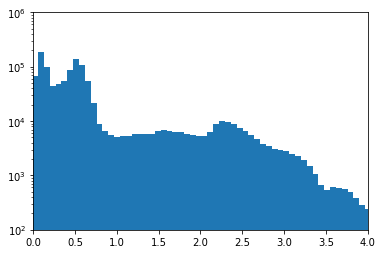

In [4]:
#Histogram plot to compare density of reference sample
fig = plt.hist(z, bins=100)
plt.xlim(0,4)
plt.yscale('log')
_=plt.ylim(10**2, 10**6)

### Reddening E(B-V) Map, Meisner and Finkbeiner 2015

From : https://lambda.gsfc.nasa.gov/product/foreground/fg_meisner_finkbeiner_2015_info.cfm


Meisner and Finkbeiner (2015) derived all-sky maps of dust temperature and dust optical depth by fitting the Finkbeiner et al. (1999) two-component dust emission model to Planck data release 1 maps from 217 to 857 GHz and a DIRBE/IRAS 100 micron map. They calibrated the optical depth map to Galactic reddening E(B-V) using reddening measurements for a large sample of stars. They note systematic problems in their results due to imperfect zodiacal light correction at large angular scales and due to cosmic infrared background anisotropy at small angular scales.

The E(B-V) map provided here was constructed using the data and software distributed by Meisner and Finkbeiner via their Planck Two-component Dust Model webpage. Their software can also be used to obtain predictions of Galactic thermal dust emission at frequencies from 100 MHz to 3000 GHz.

In [75]:
ebv2015 = np.load(full_path_dust+'EBV_2015.npy')
ebv2015_ring = hp.reorder(ebv2015, n2r=True)
ebv2015_p = hp.remove_monopole(ebv2015_ring)

monopole: 0.319053


In [6]:
hp2015 = HealpyObj(ebv2015, nest=True, coord='G')
ebv2015_arr = hp2015.getregion(grid, arr2d=True)

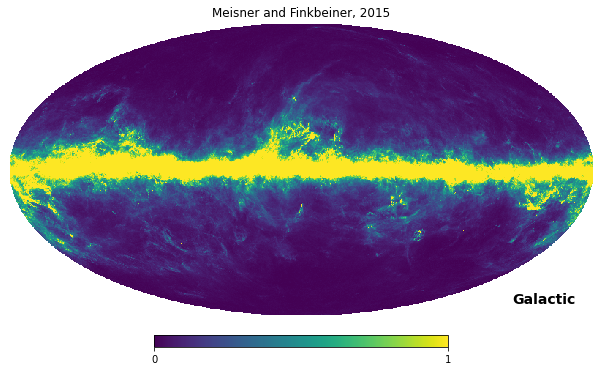

In [7]:
hp2015.set_scale('zscale')
hp2015.mollview('Meisner and Finkbeiner, 2015')

### Schlegel, Finkbeiner and Davis Reddening maps 1998

From : https://lambda.gsfc.nasa.gov/product/foreground/fg_ebv_map.cfm 



Schlegel, Finkbeiner & Davis (see 1998 reference below) derived an all-sky map of Galactic reddening, E(B-V), from a composite 100 micron map formed from IRAS/ISSA maps calibrated using DIRBE observations. This E(B-V) map can be used as an estimator of Galactic extinction.

The E(B-V) map provided here was constructed using the data and interpolation software distributed by Schlegel & Finkbeiner via their Berkeley mirror website. Specifically, their routine dust_getval was used to interpolate their high resolution dust maps onto pixel centers appropriate for HEALPix Nside=512. The resultant map is in units of magnitudes. Note that the data are undersampled at this pixelization. Additional products are available from the source websites.


In [17]:
'''
data1998 = fits.open(full_path + 'lambda_sfd_ebv.fits')[1].data
temp = data1998['TEMPERATURE'].flatten()
np.save(full_path + 'EBV_1998.npy', temp)
'''

"\ndata1998 = fits.open(full_path + 'lambda_sfd_ebv.fits')[1].data\ntemp = data1998['TEMPERATURE'].flatten()\nnp.save(full_path + 'EBV_1998.npy', temp)\n"

In [39]:

#Make ebv map a delta ebv map, but ask adrian if it is better to do so before or after removing monopoles


ebv1998 = np.load(full_path_dust + 'EBV_1998.npy')
ebv1998_over = (ebv1998-ebv1998.mean())/ebv1998.mean()
ebv1998_ring = hp.reorder(ebv1998_over, n2r=True)
ebv1998_p = hp.remove_monopole(ebv1998_ring)

monopole: -1.95888e-07


In [52]:
hp1998 = HealpyObj(ebv1998, nest=True, coord='G')
ebv1998_arr = hp1998.getregion(grid, arr2d=True)

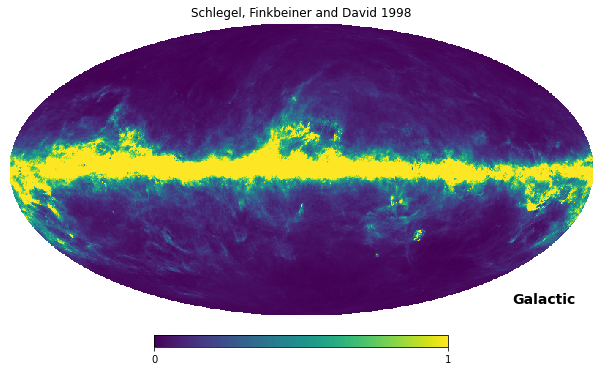

In [53]:
hp1998.set_scale('zscale')
hp1998.mollview('Schlegel, Finkbeiner and David 1998')

## Correlation

1 - $w(\theta)$ with <br><br>
iter_map : overdensity field of ref sample for given z ranges in the paper<br>
circle_map : fluctuation reddening field (1998 sample above)<br>

The error in $w(\theta)$ is over space.


In [7]:
def get_fields(ra, dec, z, ebv_map, zmin, zmax):
    mask = np.where((zmin<z) & (z<zmax))
    yrange = [0,60]
    xrange = [170,220]
    shape = (100,100)
    
    dg = DataGrid(xrange, yrange, shape, ra[mask], dec[mask])  
    hpmap = HealpyObj(ebv_map, nest=True, coord='G') #both ebv maps have nested ordering and are in galactic coord.
    
    grid = Grid2d(xrange, yrange, shape)
    grid.set_frame('fk5')
    redd_map = statsfunc.filter_arr(hpmap.getregion(grid, arr2d=True), 10)
    
    return redd_map, dg.overdensity_field()
    

In [49]:
def remove_local(m,nest=False, rad=1):
    '''
    Removes local averages from field. 
    
    Parameters:
    --------------
    m : healpy map on which we remove local averages
    
    nest : ordering of the map
    
    rad : radius of the local region
    
    
    '''
    nside = hp.get_nside(m)
    npix = hp.nside2npix(nside)
    X,Y,Z = hp.pix2vec(nside,np.arange(npix),nest=nest)
    
    return np.array([m[hp.vec2pix(nside,x,y,z, nest=nest)] - m[hp.query_disc(nside, [x,y,z], np.radians(rad))].mean() for x,y,z in tqdm(zip(X,Y,Z),total=npix)])
        

In [126]:
#get ra/dec for some z-range
ra1, dec1 = ra[np.where((0.1<z) & (z<0.2))], dec[np.where((0.1<z) & (z<0.2))] 
ra2, dec2 = ra[np.where((0.3<z) & (z<0.4))], dec[np.where((0.3<z) & (z<0.4))]
ra3, dec3 = ra[np.where((0.5<z) & (z<0.6))], dec[np.where((0.5<z) & (z<0.6))]
ra4, dec4 = ra[np.where((1.2<z) & (z<1.3))], dec[np.where((1.2<z) & (z<1.3))] 
ref1 = statsfunc.coord2hp(ra1,dec1,128)
ref2 = statsfunc.coord2hp(ra2,dec2,128)
ref3 = statsfunc.coord2hp(ra3,dec3,128)
ref4 = statsfunc.coord2hp(ra4,dec4,128)

In [122]:
ebv1998 = np.load(full_path_dust + 'EBV_1998.npy')

map1 = hp.reorder(ebv1998, n2r=True) #convert ordering to ring

map1 = hp.ud_grade(map1, 128) #degrade resolution to nside of 128

map1 = remove_local(map1) #remove local average

In [123]:
ebv2015 = np.load(full_path_dust + 'EBV_2015.npy')

map2 = hp.reorder(ebv2015, n2r=True) #convert ordering to ring

map2 = hp.ud_grade(map2, 128) #degrade resolution to nside of 128

map2 = remove_local(map2) #remove local average

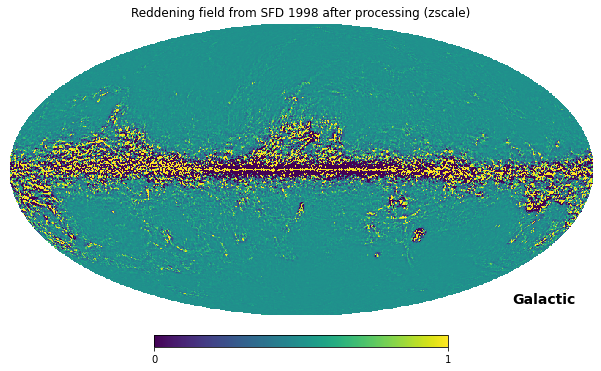

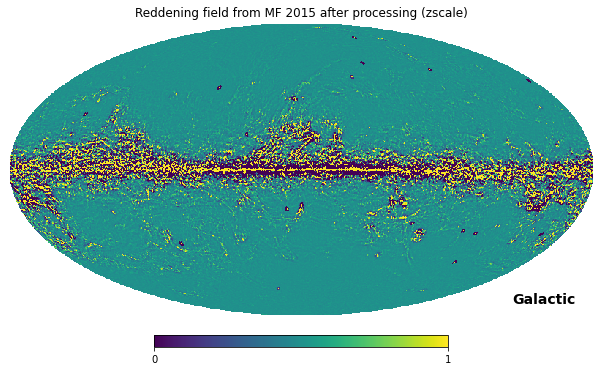

In [125]:
zscale = ZScaleInterval()
hp.mollview(zscale(map1), fig=1, title='Reddening field from SFD 1998 after processing (zscale)', coord='G')
hp.mollview(zscale(map2), fig=2, title='Reddening field from MF 2015 after processing (zscale)', coord='G')
#hp.mollview(ref1, fig=3, title='Overdensity field of reference sample for 0.1<z<0.2', coord='G')

In [127]:
def plot_corr(dust_map,*ref_maps):
    
    theta_vals = np.arange(0.01,2,0.05)
    
    plt.figure(figsize=(8,6))
    i=1
    for ref_map in ref_maps:
        result = [statsfunc.compute_corr_v2(dust_map, ref_map, theta) for theta in theta_vals]

        vals, error = zip(*result)
        error = np.array(list(error))/np.sqrt(hp.nside2npix(hp.get_nside(dust_map)))

        plt.plot(theta_vals*60, list(vals), label='ref map #'+str(i))
        plt.xscale('log')
        #plt.errorbar(theta_vals*60, list(vals), yerr=error, markersize=0, label='ref map #'+str(i))
        plt.xlabel('degrees (arcmin)')
        plt.ylabel('correlation')
        i+=1
    plt.legend()
    return 
    #ones test (uniform values for corr)
    #random tests (spike at close distance and drops down at higher distances)
    #some array with gaussian noise (no corr)
    #remove incomplete circles
    #top half of dust map
    #error bars: std over circles themselves
    #1/root(N) where N is number of bull's eye 
    #do stuff on healpix 

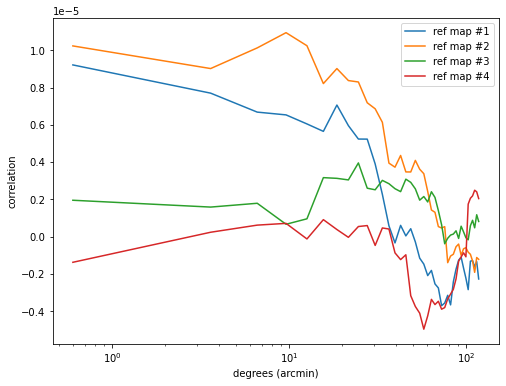

In [130]:
plot_corr(map1,ref1,ref2,ref3,ref4) #evenly spaced x-points to get evenly spaced plots on log plots

In [ ]:
#figure out why averaging averages doesnt work

In [26]:
#understand the error bars : 
#find variance of individual bull's eye w(theta) operations depending on the input standard deviation. 

'''
answer : we define the operation L : taking as input a bullseye (a ring and a scalar), it averages scalar*ring. 

this operation is what is done on the maps when doing the two-point correlation function. 

The conclusion is that the value returned by L is proportional to both the mean and the std of the input random generators.

'''

'\nanswer : we define the operation L : taking as input a bullseye (a ring and a scalar), it averages scalar*ring. \n\nthis operation is what is done on the maps when doing the two-point correlation function. \n\nThe conclusion is that the value returned by L is proportional to both the mean and the std of the input random generators.\n\n'

In [10]:
def gen_bulls_eye(mean, std, n=1000):
    return np.random.normal(mean, std, size=(n,50)).mean() * np.random.normal(mean, std, size=n).std()
    

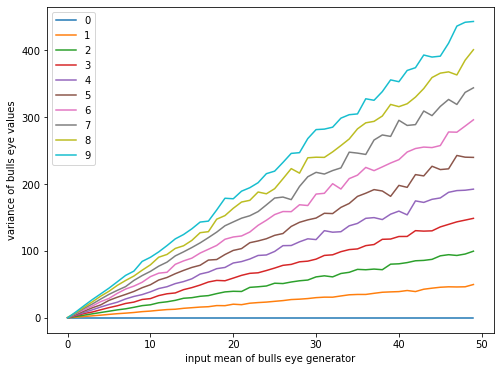

In [25]:
plt.figure(figsize=(8,6))
for std in np.arange(10):
    plt.plot(np.arange(50), [gen_bulls_eye(mean, std) for mean in np.arange(50)], label=str(std))
    plt.xlabel('input mean of bulls eye generator')
    plt.ylabel('variance of bulls eye values')
plt.legend()

In [52]:
%timeit w(m1,m2,10)

207 ms ± 17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [135]:
@interact(theta = widgets.IntSlider(min=0, max=360, step=1, value=0),
          phi = widgets.IntSlider(min=-90, max=90, step=1, value=10),
          R = widgets.IntSlider(min=0, max=90, step=1, value=10))

def vis(theta, phi, R):
    '''
    visualization tool to see what the circles we are retrieving in the w(theta) function look like.
    
    '''
    #Getting the maps
    m = np.random.normal(size=hp.nside2npix(128))
    m2 = m
    
    #Setting up parameters
    nside = hp.get_nside(m)
    vec = hp.ang2vec(theta,phi, lonlat=True)
    dr = 10*hp.nside2resol(nside)
    
    #Retrieving the index of the circle
    disk1 = hp.query_disc(nside,vec, radius=np.radians(R)+dr, nest=False)
    disk2 = hp.query_disc(nside, vec, radius =np.radians(R))
    index = np.setdiff1d(disk1,disk2, assume_unique=True)
    
    #Retrieving statistical properties of values on circle
    mean, std = m[index].mean(), m[index].std()
    values = m[index]
    m[index] = m.max()
    
    #Plotting everything
    zscale = ZScaleInterval()
    print('mean of values on circle: '+ str(mean))
    print('std of values on circle: ' +str(std))
    print('length of circle array values: '+str(len(index)))
    plt.figure(figsize=(6,4))
    plt.hist(values, bins=30)
    plt.title('occurrence of values on circle')
    hp.mollview(zscale(m))

    return

interactive(children=(IntSlider(value=0, description='theta', max=360), IntSlider(value=10, description='phi',…

In [458]:
def get_ring_len(nside, theta, nest=False):
    dr = hp.nside2resol(nside)
    npix = hp.nside2npix(nside)
    vec = hp.pix2vec(nside, 0, nest=nest)

    return hp.query_disc(nside,vec, theta+dr,nest=nest).size - hp.query_disc(nside,vec,theta,nest=nest).size 

@njit
def set_diff(lst1, lst2):
    return list(set(lst1).difference(set(lst2)))

def compute_corr(map1, map2, theta, nest=False):
    '''
    version 1 of w(theta). This version gets the whole list of possible m(r1)m(r2) using the ring method 
    to then compute <m(r1)m(r2)>. It is very explicit and thus slow. On the other hand, it is clear what the
    function does.
    
    The function is symmetric and linear. (experimentally tested, and it is also logical)
    
    Parameters:
    ------------
    map1: first healpix map
    
    map2: second healpix map
    
    theta: distance |r1-r2| in radians
    
    nest: ordering of the healpix maps
    
    '''
    if hp.get_nside(map1)!=hp.get_nside(map2):
        raise Exception('Maps are of two different resolutions.')
        
    #set healpix maps parameters
    nside = hp.get_nside(map1)
    npix = hp.nside2npix(nside)
    
    #Get the vectors associated with pixels
    X,Y,Z = hp.pix2vec(nside, np.arange(npix), nest=nest)
    
    #Fix the ring parameters
    ring_len = get_ring_len(nside, theta, nest=nest)
    dr = hp.nside2resol(nside)  
    
    
    #Function used to retrieve mean of circle with center vec and radius theta in map2
    def query_annulus(vec):
        disk1 = hp.query_disc(nside, vec, theta+dr, nest=nest)
        disk2 = hp.query_disc(nside, vec, theta, nest=nest)
        index = set_diff(disk1, disk2)

        return map2[index]
               

    
   
    it = (query_annulus([x,y,z]).sum()/ring_len for x,y,z in tqdm(zip(X,Y,Z), total=npix))
    
    ans = map1 * np.fromiter(it, dtype=np.float)
    return  ans.mean(), ans.std()